# PS3

## 1. Niño 3.4 index

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
da = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc",engine="netcdf4")

### 1.1 [5 points] Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

In [37]:
weights = np.cos(np.deg2rad(da.lat))
sst_weighted = da.sst.sel(lat=slice(-5,5),lon=slice(210,240)).weighted(weights)
region_mean = sst_weighted.mean(dim=('lon','lat'))
monthly_sst = region_mean.groupby('time.month').mean()
x = region_mean.size
anoma = np.zeros(x-2)
for i in range(0,x-2):
    k = i % 12
    anoma[i] = region_mean[i] - monthly_sst[k]

##  The criteria, that is often used to classify El Niño episodes, 
# is that five consecutive 3-month running mean SST anomalies exceed the threshold.
def moving_average(x,w):
    return np.convolve(x, np.ones(w),'valid') / w

mean_anoma = moving_average(anoma,3)


### 1.2 [5 points] Visualize the computed Niño 3.4. 

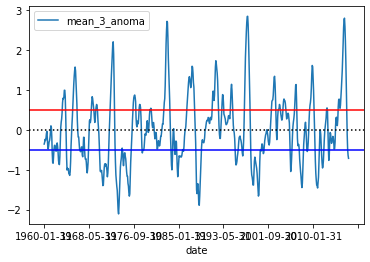

In [38]:
# create a dataframe
# 'JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','OND','NDJ','DJF'
alist = ['JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','OND','NDJ','DJF']
templist=[]
for i in range(0,68):
    for j in range(0,10):
        templist.append(alist[j])
templist.append('JFM')
templist.append('FMA')
df = pd.DataFrame(mean_anoma,columns=['mean_3_anoma'])
df['mo'] = pd.DataFrame(templist)
def get_date_list(begin_date,end_date):
    date_list = [x.strftime('%Y-%m-%d') for x in list(pd.date_range(start=begin_date,end=end_date,freq='M'))]
    return date_list
date = get_date_list('1960-01-15','2016-12-15')
df['date'] = pd.DataFrame(date)

# Visualize the computed Niño 3.4.
df.plot(x="date",y="mean_3_anoma")
plt.axhline(y=0.5,ls="-",c="red")#添加水平直线
plt.axhline(y=0,ls=":",c="black")#添加水平直线
plt.axhline(y=-0.5,ls="-",c="blue")#添加水平直线

## 2. Earth’s energy budget

In [183]:
d = xr.open_dataset('D:\jupyter\CERES_EBAF-TOA_200003-201701.nc',engine='netcdf4')
d

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

### 2.1 [5 points] Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

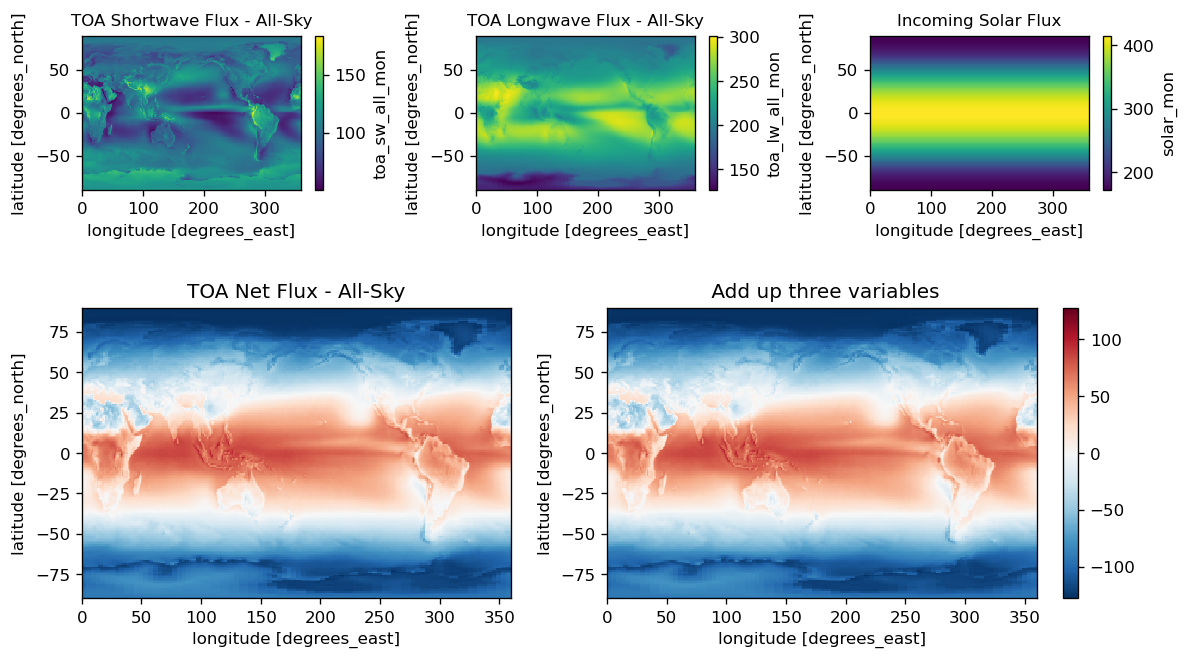

In [50]:
fig = plt.figure(figsize=(10,6), dpi=120)
grid = plt.GridSpec(5, 9)  # 3 rows 3 cols

plt.subplot(grid[0:2, 0:3])
ax1 = d.toa_sw_all_mon.mean(dim='time').plot()
plt.title('TOA Shortwave Flux - All-Sky',fontsize=10)

plt.subplot(grid[0:2, 3:6])
ax2 = d.toa_lw_all_mon.mean(dim='time').plot()
plt.title('TOA Longwave Flux - All-Sky',fontsize=10)

plt.subplot(grid[0:2, 6:9])
ax3 = d.solar_mon.mean(dim='time').plot()
plt.title('Incoming Solar Flux',fontsize=10)

plt.subplot(grid[2:5, 0:5])
ax4 = d.toa_net_all_mon.mean(dim='time').plot()
plt.title('TOA Net Flux - All-Sky')

plt.subplot(grid[2:5, 4:10])
ax5 = (d.solar_mon.mean(dim='time') - d.toa_sw_all_mon.mean(dim='time') - d.toa_lw_all_mon.mean(dim='time') ).plot()
plt.title(' Add up three variables')

plt.tight_layout()

### 2.2 [10 points] Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.

[Hint: Consider calculating the area of each grid]

<xarray.DataArray ()>
array(1.6990367, dtype=float32)

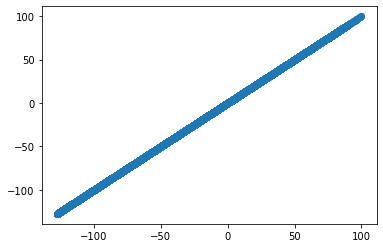

In [34]:
temp=[]
x = d.solar_mon.mean(dim='time') - d.toa_sw_all_mon.mean(dim='time') - d.toa_lw_all_mon.mean(dim='time')
y = d.toa_net_all_mon.mean(dim='time')
a = plt.scatter(x,y)
(x-y).sum()

### 2.3 [5 points] Calculate and plot the total amount of net radiation in each 1-degree latitude band. Label with correct units.

Text(0, 0.5, 'toa_net_all_mon/ W')

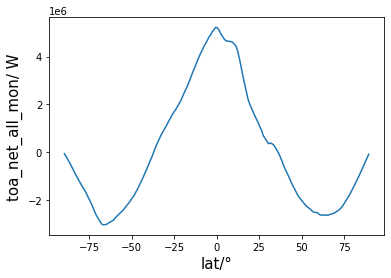

In [223]:
weights = np.cos(np.deg2rad(d.lat))
net_weighted = d.toa_net_all_mon.weighted(weights)
region_mean = net_weighted.sum(dim=['lon','time']).plot()
plt.xlabel('lat/°',fontsize=15)
plt.ylabel('toa_net_all_mon/ W',fontsize=15)

### 2.4 [5 points] Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions. Here we define low cloud area as ≤25% and high cloud area as ≥75%. Your results should be 2D maps.

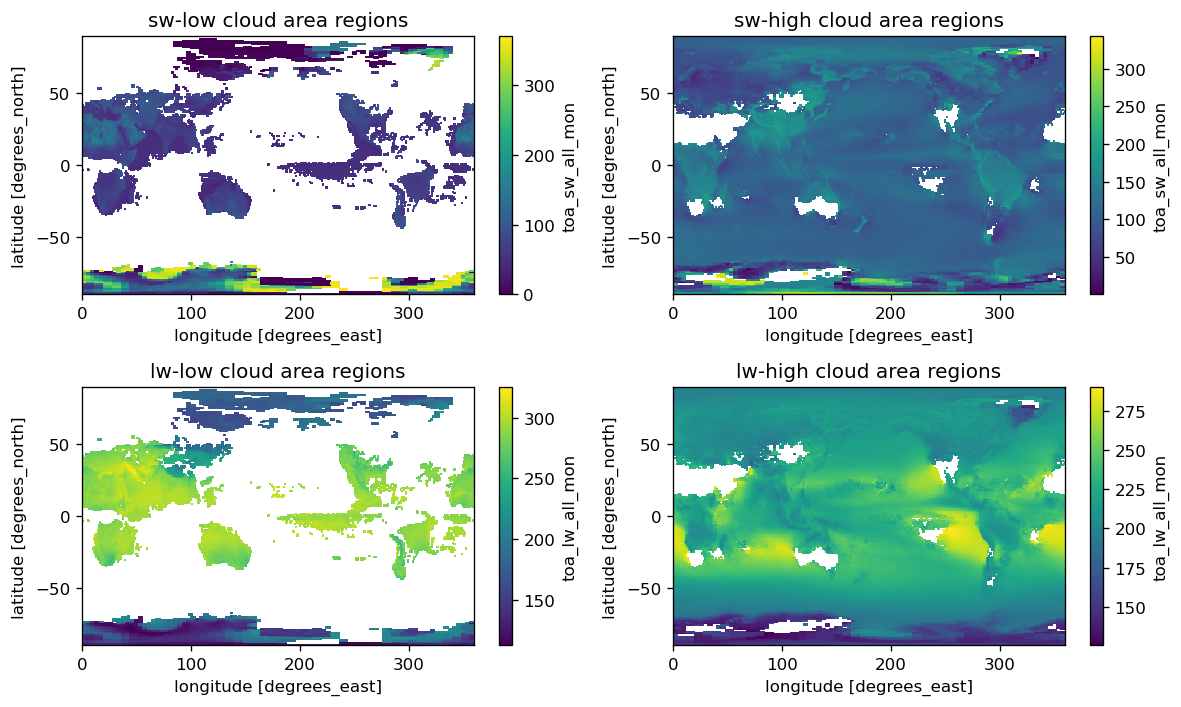

In [15]:
fig = plt.figure(figsize=(10,6), dpi=120)
grid = plt.GridSpec(4, 4)  # 4 rows 4 cols
plt.subplot(grid[0:2, 0:2])
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon<=25)).mean(dim='time').plot()
plt.title('sw-low cloud area regions')
plt.subplot(grid[0:2, 2:4])
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon>=75)).mean(dim='time').plot()
plt.title('sw-high cloud area regions')
plt.subplot(grid[2:4, 0:2])
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon<=25)).mean(dim='time').plot()
plt.title('lw-low cloud area regions')
plt.subplot(grid[2:4, 2:4])
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon>=75)).mean(dim='time').plot()
plt.title('lw-high cloud area regions')

plt.tight_layout()

### 2.5 [5 points] Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions. What is the overall effect of clouds on shortwave and longwave radiation?

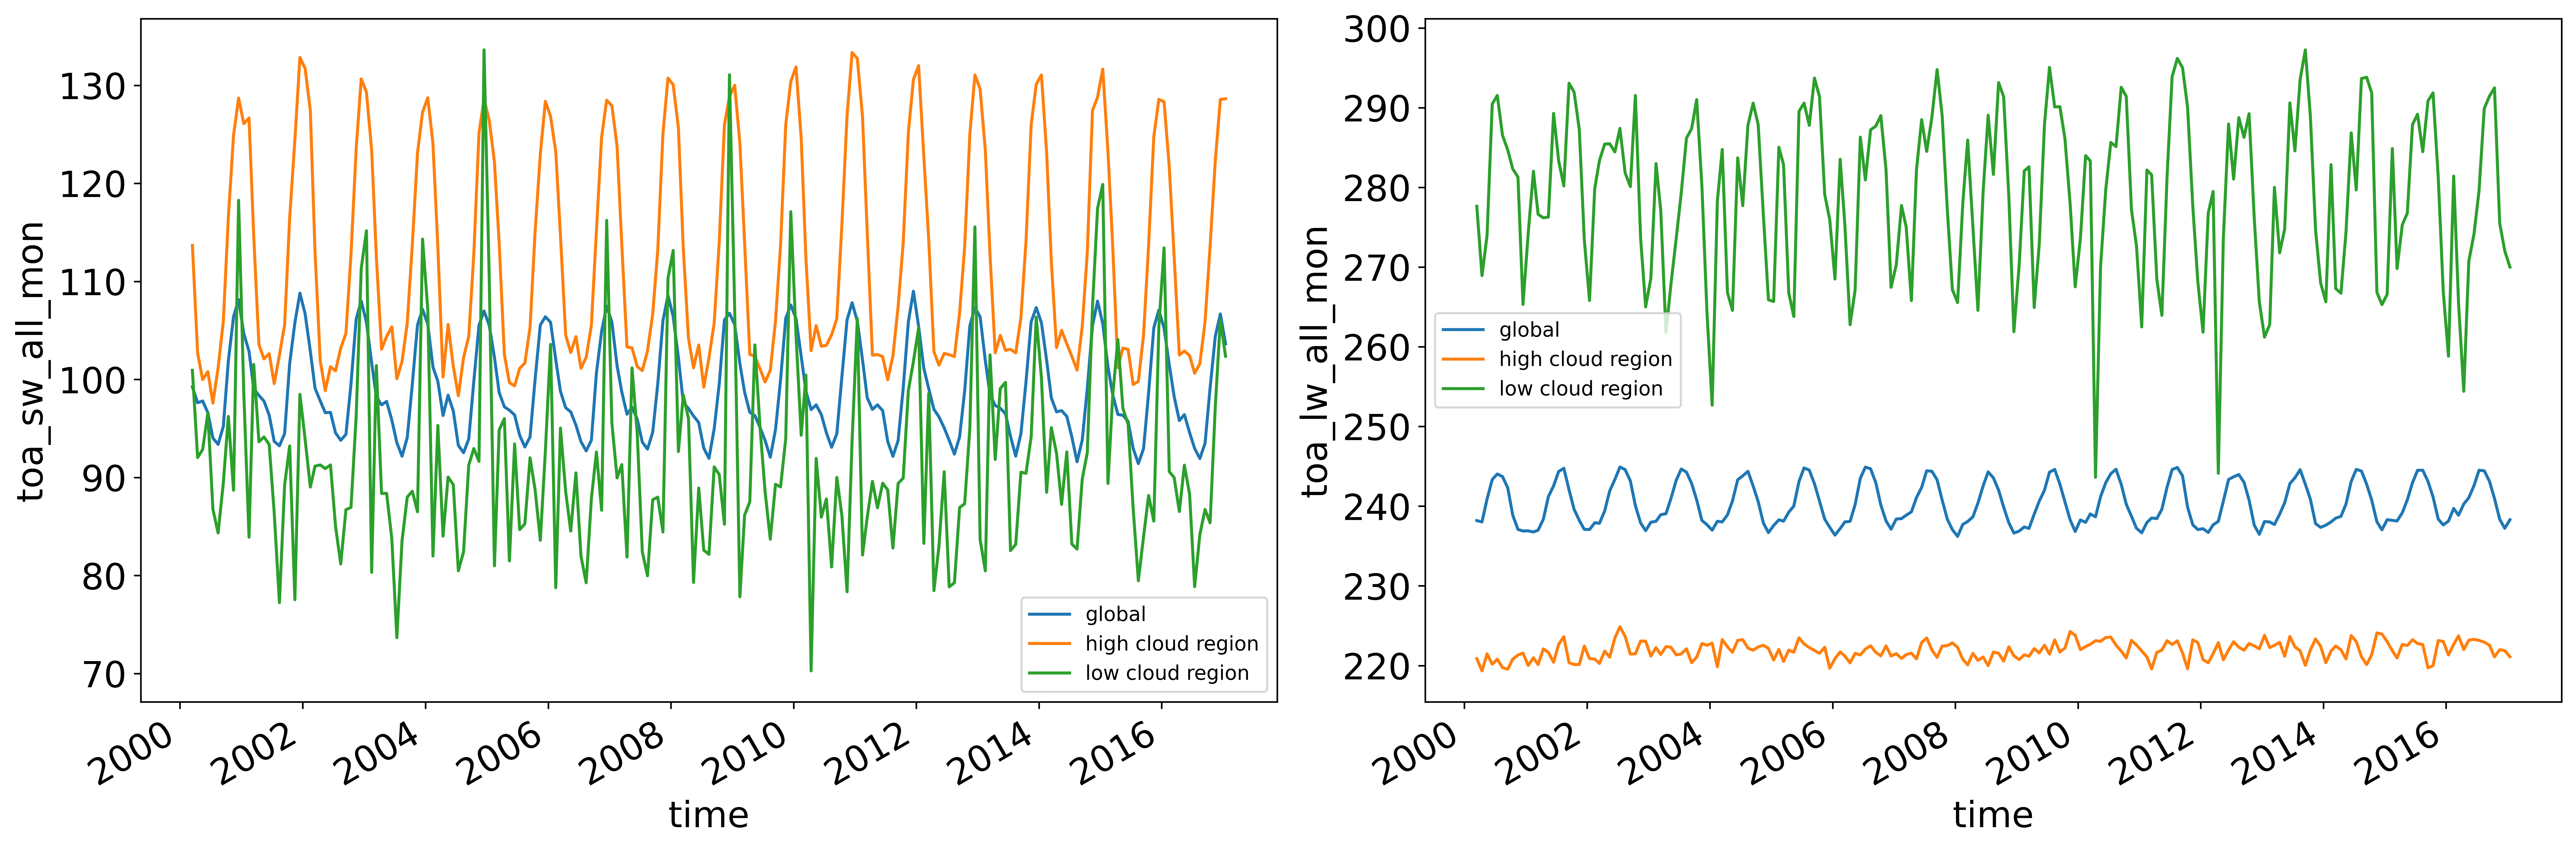

In [222]:
fig = plt.figure(figsize=(18,6), dpi=600)
grid = plt.GridSpec(1, 2)  # 1 rows 2 cols
plt.subplot(grid[0, 0])
d.toa_sw_all_mon.weighted(weights).mean(dim=['lon','lat']).plot(label='global')
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon>=75)).weighted(weights).mean(dim=['lon','lat']).plot(label='high cloud region')
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon<=25)).weighted(weights).mean(dim=['lon','lat']).plot(label='low cloud region')
plt.legend(loc='best')
plt.xlabel('time',fontsize=18)
plt.ylabel('toa_sw_all_mon',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.subplot(grid[0, 1])
d.toa_lw_all_mon.weighted(weights).mean(dim=['lon','lat']).plot(label='global')
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon>=75)).weighted(weights).mean(dim=['lon','lat']).plot(label='high cloud region')
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon<=25)).weighted(weights).mean(dim=['lon','lat']).plot(label='low cloud region')
plt.legend(loc='best')
plt.xlabel('time',fontsize=18)
plt.ylabel('toa_lw_all_mon',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# 3. Explore a netCDF dataset

In [114]:
T = xr.open_dataset('2016-2020-T.nc',engine="netcdf4")
T.t2m.mean(dim=('latitude', 'longitude'))

<xarray.DataArray 't2m' (time: 43848)>
array([286.67023, 288.65994, 289.85648, ..., 278.07663, 277.76575,
       277.50546], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2020-12-31T23:00:00

### 3.1 [5 points] Plot a time series of a certain variable with monthly seasonal cycle removed.

<AxesSubplot:xlabel='year,month'>

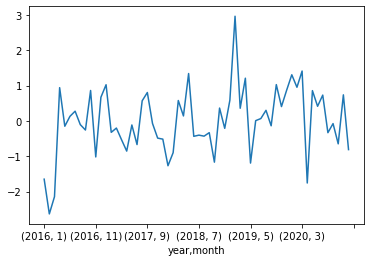

In [174]:
weight = np.cos(np.deg2rad(T.latitude))
T_weighted = T.t2m.weighted(weight)
region_mean = T_weighted.mean(dim=('longitude','latitude'))
a = region_mean.values
index = pd.date_range('2016-01-01', periods=1827, freq='D')
k = 0
t_day = np.zeros(1827)
for i in range(0,1827):
    t_day[i]=a[k:k+24].mean()
    k+=24
tempdf = pd.DataFrame(t_day,columns=['t2m'])
tempdf['date'] = index
tempdf['year'] = pd.DatetimeIndex(tempdf.date).year
tempdf['month'] = pd.DatetimeIndex(tempdf.date).month
t_month = tempdf.groupby(['year','month']).mean()


monthly_T = region_mean.groupby('time.month').mean()
sea = np.zeros(60)
for i in range(0,5):
    sea[12*i:12*i+12] = monthly_T

certain = t_month['t2m'] - sea
certain.plot()

### 3.2 [5 points] Make at least 5 different plots using the dataset.

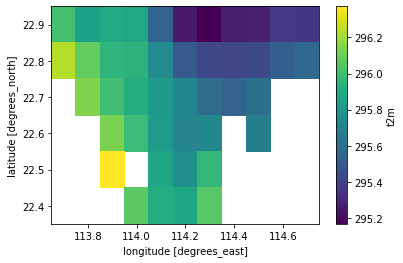

In [149]:
T.t2m.mean(dim='time').plot()

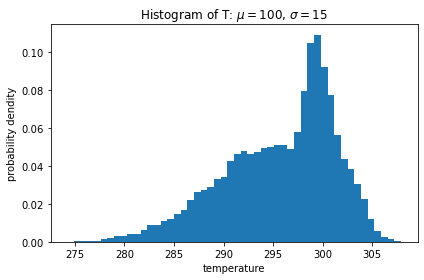

In [172]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(0)

# example data
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = a

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# Tweak spacing to prevent clipping of ylabel
plt.title('Histogram of T: $\mu=100$, $\sigma=15$')
plt.xlabel('temperature')
plt.ylabel('probability dendity')
fig.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x12692be2f70>,
 'caps': [<matplotlib.lines.Line2D at 0x12692be2c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x12692be2ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x12692c30700>],
 'fliers': [<matplotlib.lines.Line2D at 0x12692c30b80>],
 'means': []}

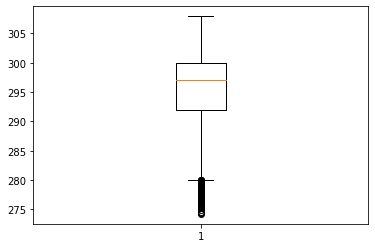

In [176]:
data = a
# basic plot
plt.boxplot(data)

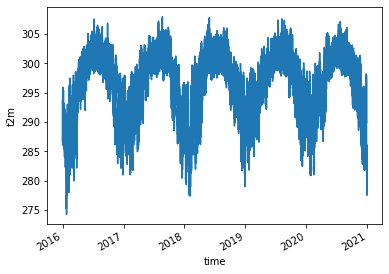

In [180]:
T_weighted.mean(dim=('longitude','latitude')).plot()

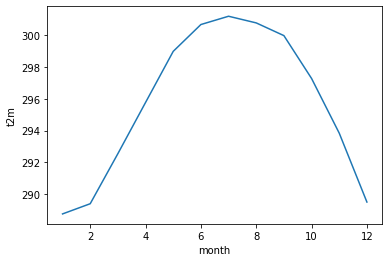

In [195]:
monthly_T.plot()